In [1]:
#v1 uses S2023's empirical formula fo survival fraction
#v2 has the option of using our analytical formula for the survival fraction.


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import simpson
import scipy.integrate as si
import pickle
import seaborn as sns
import scipy.optimize as so
import sympy as sp
import math
import concurrent.futures
import random
import os
import requests

In [2]:
# CHOOSE between the minimum adiabatic halo mass M_min_adiabatic = 10^2 MSolar and M_min_adiabatic = 10^{-2} MSolar
# Note that this script actually loads the filled countour plots information from the Data folder. Changing 'M_min_adiabatic' generates the fillled contour plot information for that value of 'M_min_adiabatic'.
# You can save this information by setting 'save_countour = True' below.
M_min_adiabatic = 1e2 # measured in Solar masses. #Change to 1e-2 for M_min_adiabatic = 10^{-2} MSolar


save_contour = False # Set to True if you want to save the filled contour plot information for M_min_adiabatic = 10^2 MSolar or M_min_adiabatic = 10^{-2} MSolar.  This will save the information in the Data folder.
# The filled contour information has already been saved to the Data folder.  So, no need to set this to True unless you want to regenerate the filled contour plot information. 

In [3]:
# PARAMETERS

# m_a = 1.25  # measured in micro eV
m_a = 25  # measured in micro eV
# m_a = 500  # measured in micro eV

In [4]:
with open(r'..\Data\SF interpolator.pickle', 'rb') as f:
    # Read out object  from file
    rgi = pickle.load(f)  #interpolation function for our SF(Efrac, c). 

In [5]:
rgi(np.array([[1e2, 100], [1e0, 100]])) #Efrac, c

array([0.22606943, 0.61536183])

In [6]:
# Set up mass-concentration relationship
if m_a == 1.25:
    with open(r'..\Data\mass_conc_1p25_mueV_interpolator.pkl', 'rb') as file:
        concentration_mass_interpolator = pickle.load(file)
elif m_a == 25:
    with open(r'..\Data\mass_conc_25_mueV_interpolator.pkl', 'rb') as file:
        concentration_mass_interpolator = pickle.load(file)
elif m_a == 500:
    with open(r'..\Data\mass_conc_500_mueV_interpolator.pkl', 'rb') as file:
        concentration_mass_interpolator = pickle.load(file)
else:
    raise ValueError("For axion mass 'm_a', please choose from one of the following values in units of mueV: 1.25, 25, 500")
# To use the above interpolator, pass as argument the mass of minihalo. The interpolator will output 'concentration X (1 + infall_redshift)'

# Set up collpase fraction and derivative of colapse functions relationship with respect ot redhsift
if M_min_adiabatic == 1e-2:
    with open('collapse_fraction_interpolation_wrong_Mmin.pickle', 'rb') as f: #Mmin=1e-2 
        get_collapse_fraction_S2023 = pickle.load(f)

    with open('derivative_of_collapse_fraction_interpolation_wrong_Mmin.pickle', 'rb') as f:
        get_derivative_of_collapse_fraction_S2023 = pickle.load(f) #Mmin=1e-2 
elif M_min_adiabatic == 1e2:
    with open(r'..\Data\collapse_fraction_interpolation.pickle', 'rb') as f: 
        get_collapse_fraction_S2023 = pickle.load(f) #is using S2023 Mmin=1e2

    with open(r'..\Data\derivative_of_collapse_fraction_interpolation.pickle', 'rb') as f:
        get_derivative_of_collapse_fraction_S2023 = pickle.load(f) #is using S2023 Mmin=1e2
else:
    print("Error: Choose between M_min_adiabatic = 1e2 or M_min_adiabatic = 1e-2")

# Set up isocurvature growth function: Input: redshift; Output: Isocurvature gorwth factor
with open(r'..\Data\growth_function.pickle', 'rb') as f:
    get_isocurvature_growth_factor = pickle.load(f)

# Get matter denisty today IN MSOLAR / MPC^3
rho_m_today_MSolar_Mpc3 = np.load(r"..\Data\rho_matter_today.npy")
# Convert to MSolar / pc^3
rho_m_today = rho_m_today_MSolar_Mpc3 / 1e18

# # Get cold dark matter density today
# rho_cdm_today = np.load(r"rho_cdm_today.npy")

# Load the Sigmas_star array which has data type = object. It contains 1e6 1-dim numpy arrays, each corresponding to a given orbit generated by the Monte Carlo algorithm
# Each 1-dim numpy array consists of the effective stellar surface densities corresponding to given MW disk passes by the minhalo 
# REMEMBER that Sigma_star is got from lbparticles code which calculates it in units of solar masses / pc^2. This must be changed to solar masses / m^2 to use in this Jupyter notebook.
file_url = 'https://github.com/ian-dsouza/axion-minihalos-2/releases/download/Data/Sigmas_star_uptill_zi.pkl'
local_filename = 'Sigmas_star_uptill_zi.pkl'

if not os.path.exists(local_filename):
    print(f'Downloading {local_filename}...')
    response = requests.get(file_url)
    with open(local_filename, 'wb') as f:
        f.write(response.content)
    print('Download complete.')
else:
    print(f'{local_filename} already exists.')

# Proceed to load the pickle file
import pickle
with open(local_filename, 'rb') as f:
    Sigmas_star_all_orbits = pickle.load(f) # measured in solar masses / pc^2

# Load the flags. Flags is a 2 rows X 1e6 columns numpy array.
# If flag[index, 0] = 1, the first disk pass for that orbit given by 'index' is a partial disk crossing. When calculating b_c, we must use the average Sigma_star (effective stellar surface density) for a disk crossing
# If flag[index, 1] = 1, the last disk pass for that orbit given by 'index' is a partial disk crossing. When calculating b_c, we must use the average Sigma_star (effective stellar surface density) for a disk crossing
flags_bc = np.load(r'..\Data\flags_double_bc_uptill_zi.npy')

# # Load the time stamps of of stellar encounters (effective disk passes) for the during of a given orbit, for all orbits.
# # It is of the form: np.empty((1e6,), dtype=object)
# with open(r'C:\Users\ids29\OneDrive - University of Canterbury\UC PhD - auxiliary storage\.pkl', 'rb') as f:
#     times_stamp_encounter_all_orbits = pickle.load(f) # measured in solar masses / pc^2

Download complete.


In [7]:
delta_c = 1.686
A_osc = 0.1
M_0 = 2.3e-10 * (50 / m_a)**0.51  # measured in solar masses
k = np.sqrt(3 * A_osc * M_0 / (2 * np.pi**2))

A = 0.374
p = 0.19
q = 1.2

def pre_infall_mass_function(M, z):
    D1_z = get_isocurvature_growth_factor(z)

    dnu_dM = delta_c**2 / (D1_z**2 * k**2)
    sigma = D1_z * k / np.sqrt(M)
    nu = delta_c**2 / sigma**2
    f_of_nu = A * ( 1 + (q * nu)**(-p) ) * np.sqrt( q / (2 * np.pi * nu) ) * np.exp(- q * nu / 2)
    return rho_m_today / M * f_of_nu * dnu_dM

In [8]:
eta = 0.987
a1 = -0.8
a2 = -0.586
a3 = -0.034
b0 = -0.583
b1 = -0.559

# S2023's empirical fitting function 
def survival_fractionS2023(Efrac, c): 
    p = 10**( a1*(np.log10(c) - eta) + a2*(np.log10(c) - eta)**2 + a3*(np.log10(c) - eta)**3 )
    k = 10**( b0 + b1*(np.log10(c) - 2) )  
    survival_fraction = 2 / ( 1+ (1 + Efrac/p)**k )
    return survival_fraction

In [9]:
# Output is concentration
def get_concentration_from_mass(mass, z_i):
    c_times_1PlusZi =  concentration_mass_interpolator(mass)
    
    return c_times_1PlusZi / (1 + z_i)

In [10]:
num_zi_samples = int(1e3) + 1 # So that the M X z_i gird will be 1,000 X 1,000
num_mass_samples = int(1e3)

zi_min = 0
zi_max = 150
one_plus_zs_i = np.geomspace(1 + zi_min, 1 + zi_max, num_zi_samples)
zs_i_grid = one_plus_zs_i - 1
Delta_zs_i = zs_i_grid[1:] - zs_i_grid[0:-1] # interval between two consecutive values of z_i in zs_i array

probs_infall_S2023 = abs(get_derivative_of_collapse_fraction_S2023(zs_i_grid[0:-1]))  *  Delta_zs_i # absolute value is taken because derivative of collapse fraction with respect to z_i is negative and probabilities can't be negative.

M_min = 1e-14 #1.0403991770513538e-12 # measured in solar masses
M_max = 1e-3 #8.026015608726264e-06 # measured in solar masses
masses_grid = np.geomspace(M_min, M_max, num_mass_samples)

number_densities = np.zeros([num_zi_samples - 1, num_mass_samples])
weights_S2023 = np.zeros([num_zi_samples - 1, num_mass_samples])
for i, z_i in enumerate(zs_i_grid[0:-1]):
    number_densities[i, :] = pre_infall_mass_function(masses_grid, np.repeat(z_i, num_mass_samples))
    # weights[i, :] = number_densities[i, :] * np.repeat(probs_infall[i], num_mass_samples) #X2021 eq 5 with second term neglegted, Mmin=1e-2 solar masses for the collapse fraction
    weights_S2023[i, :] = number_densities[i, :] * np.repeat(probs_infall_S2023[i], num_mass_samples) #Mmin=1e2 solar masses for the collapse fraction

# Compute concentrations
concentrations = np.zeros([num_zi_samples - 1, num_mass_samples])
for i, z_i in enumerate(zs_i_grid[0:-1]):
    for j, mass in enumerate(masses_grid):
        concentrations[i, j] = get_concentration_from_mass(mass, z_i)

In [11]:
def compute_fNFW(x):
    return np.log(1 + x) - x / (1 + x)

In [12]:
# Compute the average E_frac during the Hubble time (life time of the minihalo)
# For a given orbit, we simply add the E_frac values corresponding to each disk pass to get the net E_frac for that orbit.
# We find the average of net E_fracs corresponding to all orbits generated by the Mopnte Carlo algorithm

##### Parameters
# Length - pc
# Mass - solar masses
# Time - Myr

G_SIunits = 6.6743e-11 # mesaured in SI units
# r_obs_kpc = 8 #measured in kpc - at solar neighborhood in MW galaxy
m_K = 0.6 # measured in solar masses
sigma_star_squared_plus_v_mh_squared_km_s = 250**2 # measured in km^2 / s^2
f_b = 6
Delta_c = 200

Omega_rad = 8.6113e-5
Omega_m = 0.2814
Omega_lambda = 0.7186
H0_usual_units = 69.7 # measured in km/s/Mpc

# Convert above dimensional quantities to pc, solar masses, Myr
G = G_SIunits * (3.24078e-17)**3 / 5.02785e-31 / (3.17098e-8 * 1e-6)**2 # measured in pc^3 / solar masses / Myr^2
sigma_star_squared_plus_v_mh_squared = sigma_star_squared_plus_v_mh_squared_km_s * (3.24078e-14)**2 / (3.17098e-8 * 1e-6)**2 # measured in pc^2 / Myr^2
H0 = H0_usual_units * 3.24078e-20 / (3.17098e-8 * 1e-6) # measured in Myr^(-1)



In [13]:
E_frac_total_2Dgrid = np.zeros([num_zi_samples - 1, num_mass_samples]) # use for the S2023 case
# E_frac_total_2Dgrid_new = np.zeros([num_zi_samples - 1, num_mass_samples]) #will be used for the 1e2 case



bs_c_squared_all_orbits = np.empty((Sigmas_star_all_orbits.size,), dtype=object)
# Compute b_c^2 for all orbits
for k, Sigmas_star in enumerate(Sigmas_star_all_orbits): # Sigmas_star_lbparticles_units is a 1-dim numpy array that contains the effective stellar surface density of each disk pass for a given orbit.
                                                                     # The units are solar masses / pc^2

    bs_c_squared = np.clip(m_K / (np.pi * Sigmas_star) , -1.8e308, 0.8e308) # is a 1-dim numpy array that contains the values of b_c^2 for each disk pass for a given orbit. This does NOT take into account the flags.
                                                                            # Measured in pc^2. Used the clip(,,) function because extermely small values of Sigma_star can cause 'bs_c_squared' to go beyond the range of
                                                                            # allowable float values in Python


    bs_c_squared_all_orbits[k] = bs_c_squared

print("Finished calculating b_c^2 for all disk passes for all orbits")


index = 1000 # index to access 'Sigmas_star_all_orbits' and 'bs_c_squared_all_orbits'. We are not processing indices 0 to 999 in the following nested 'for' loops. These indices correspond to z_i = 0 and hence E_frac = 0.


Ms_alpha_bar = []
zs_i_alpha_bar = []

for i, z_i in enumerate(zs_i_grid[0:-1]):

    if i == 0:
        continue

    H = H0 * np.sqrt(Omega_rad*(1 + z_i)**4  +  Omega_m*(1 + z_i)**3  +  Omega_lambda) # Compute Hubble paramter at z=z_i; measured in Myr^(-1))

    rho_crit_zi = (3 * H**2) / (8 * np.pi * G) #measured in solar masses / pc^3

    rho_vir = Delta_c * rho_crit_zi # Virial density of minihalo, measured in solar masses /pc^3

    for j, mass in enumerate(masses_grid):

        c = concentrations[i, j]
        alpha_squared = 3/c**2 + 1/(2*compute_fNFW(c))*(c-3)/(c+1)
        alpha = alpha_squared**(1/2)
        gamma = (c**3 - 2*c*(1+c)*compute_fNFW(c)) / (2*(1+c)**2 * (compute_fNFW(c))**2)
        alpha_bar_squared = (c**2 * np.log(100) + c**2 / 2 - 1/2) / compute_fNFW(c)
        if alpha_bar_squared < 0:
            zs_i_alpha_bar.append(z_i)
            Ms_alpha_bar.append(mass)
            alpha_bar_squared = 1e-12
        alpha_bar = alpha_bar_squared**(1/2)

        
        R_mh = ( (3*mass) / (4*np.pi*rho_vir) )**(1/3) # measured in pc
        b_s = f_b * ( (2*alpha) / (3*alpha_bar) )**(1/2) * R_mh # measured in pc

        # Compute E_frac

        Sigmas_star = Sigmas_star_all_orbits[index] # One robit is randomly picked based on the ordering in 'indices_access_orbit'
        bs_c_squared = bs_c_squared_all_orbits[index] # One robit is randomly picked based on the ordering in 'indices_access_orbit'
        index += 1

        Es_frac_disk_pass = ( G * m_K * Sigmas_star / sigma_star_squared_plus_v_mh_squared
                        * alpha_squared / gamma / Delta_c / rho_crit_zi
                        * 2 / (b_s**2 + 2*bs_c_squared) )
        
        E_frac_total_2Dgrid[i, j] = Es_frac_disk_pass.sum() # Linear addition of E_frac values of each disk pass - as proposed by S2023
        


zs_i_alpha_bar = np.array(zs_i_alpha_bar)
Ms_alpha_bar = np.array(Ms_alpha_bar)



  

C:\Users\ids29\AppData\Local\Temp\ipykernel_23964\1116730794.py:11: RuntimeWarning: overflow encountered in divide
  bs_c_squared = np.clip(m_K / (np.pi * Sigmas_star) , -1.8e308, 0.8e308) # is a 1-dim numpy array that contains the values of b_c^2 for each disk pass for a given orbit. This does NOT take into account the flags.


Finished calculating b_c^2 for all disk passes for all orbits


In [14]:
E_frac_1D_temp = E_frac_total_2Dgrid.reshape(1, -1)[0]
concentrations_1D_temp = concentrations.reshape(1, -1)[0]
weights_1D = weights_S2023.reshape(1, -1)[0]
input_pairs = np.zeros((E_frac_1D_temp[1000:].size, 2))
for i, Efrac in enumerate(E_frac_1D_temp[1000:]):
    input_pairs[i, 0] = Efrac
    input_pairs[i, 1] = concentrations_1D_temp[i]     

print(input_pairs.shape)

(999000, 2)


Joint PDF of E_frac and concentration - with weights

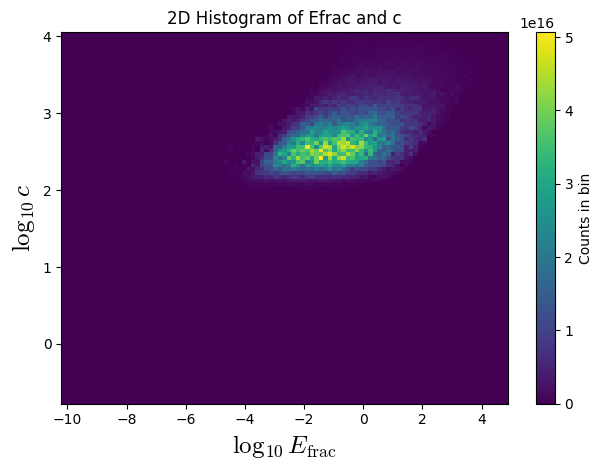

In [15]:
plt.rcParams["mathtext.fontset"] = "cm"

num_bins = 100
Efrac_bins = np.linspace(np.log10(E_frac_1D_temp[1000:].min()), np.log10(E_frac_1D_temp[1000:].max()), num_bins)
c_bins = np.linspace(np.log10(concentrations_1D_temp[1000:].min()), np.log10(concentrations_1D_temp[1000:].max()), num_bins)
plt.hist2d(np.log10(E_frac_1D_temp[1000:]), np.log10(concentrations_1D_temp[1000:]), bins=[Efrac_bins, c_bins], weights=weights_1D[1000:])

# Add a colorbar to show intensity
plt.colorbar(label='Counts in bin')
# plt.xscale("log")
# plt.yscale("log")
# Add labels and title
plt.xlabel(r"$\log_{10}E_{\rm frac}$", fontsize=18)
plt.ylabel(r"$\log_{10}c$", fontsize=18)
plt.title('2D Histogram of Efrac and c')
plt.tight_layout()
# plt.savefig("2D histogram of Efrac and concentration - with weights.png")
plt.show()

Draw 95% filled contour

1.2659707605063657e+19
fraction = 0.40%
fraction = 0.79%
fraction = 1.18%
fraction = 1.56%
fraction = 1.94%
fraction = 2.31%
fraction = 2.68%
fraction = 3.05%
fraction = 3.42%
fraction = 3.78%
fraction = 4.13%
fraction = 4.48%
fraction = 4.83%
fraction = 5.17%
fraction = 5.52%
fraction = 5.86%
fraction = 6.21%
fraction = 6.55%
fraction = 6.88%
fraction = 7.22%
fraction = 7.55%
fraction = 7.89%
fraction = 8.22%
fraction = 8.55%
fraction = 8.88%
fraction = 9.21%
fraction = 9.54%
fraction = 9.86%
fraction = 10.19%
fraction = 10.51%
fraction = 10.82%
fraction = 11.14%
fraction = 11.45%
fraction = 11.76%
fraction = 12.08%
fraction = 12.39%
fraction = 12.70%
fraction = 13.00%
fraction = 13.31%
fraction = 13.61%
fraction = 13.91%
fraction = 14.21%
fraction = 14.51%
fraction = 14.81%
fraction = 15.10%
fraction = 15.39%
fraction = 15.69%
fraction = 15.98%
fraction = 16.27%
fraction = 16.55%
fraction = 16.84%
fraction = 17.13%
fraction = 17.42%
fraction = 17.70%
fraction = 17.99%
fraction = 18.2

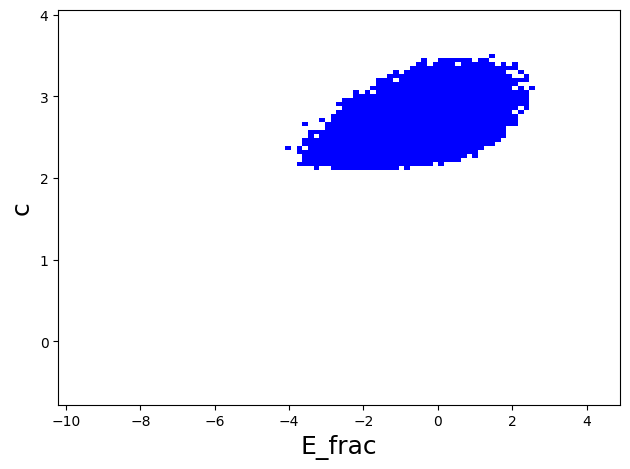

In [16]:
import matplotlib.colors as mcolors

contour_fraction = 0.95

num_bins = 100
Efrac_bins = np.linspace(np.log10(E_frac_1D_temp[1000:].min()), np.log10(E_frac_1D_temp[1000:].max()), num_bins)
c_bins = np.linspace(np.log10(concentrations_1D_temp[1000:].min()), np.log10(concentrations_1D_temp[1000:].max()), num_bins)
counts, Efrac_bin_edges, c_bin_edges = np.histogram2d(np.log10(E_frac_1D_temp[1000:]), np.log10(concentrations_1D_temp[1000:]), bins=[Efrac_bins, c_bins], weights=weights_1D[1000:])

counts_1D = counts.reshape(1,-1)[0]
# Sort in descending order
counts_descending_integers = np.sort(counts_1D)[::-1]

total_counts = np.sum(counts)
print(total_counts)

for i, count in enumerate(counts_descending_integers):
    fraction = sum(counts[counts >= count]) / total_counts
    print(f"fraction = {fraction * 100 :.2f}%")
    if fraction >= contour_fraction:
        filled_contour_bool = counts >= count
        break

cmap = mcolors.ListedColormap(['white', 'blue'])  # Set color for True/False
bounds = [-0.5, 0.5, 1.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

mesh = plt.pcolormesh(Efrac_bins, c_bins, filled_contour_bool.T, cmap=cmap, norm=norm)
plt.xlabel("E_frac", fontsize=18)
plt.ylabel("c", fontsize=18)
plt.tight_layout()
# plt.savefig(f"{contour_fraction*100} percent contour - filled - lower resolution.pdf")

plt.show()

Draw contour lines from filles contour

In [17]:
def is_point_on_contour_line(bool_array, index):
    # Bool array is a 2D array
    # index is a tuple of length 2

    if index[0] >= bool_array.shape[0]  or  index[1] >= bool_array.shape[1]:
        raise ValueError("Index is out of bounds of array dimensions")

    x_directions = np.array([-1, -1, -1, 0, 0, 1, 1, 1])
    y_directions = np.array([-1, 0, 1, -1, 1, -1, 0, 1])

    flag_contour_line = False
    for i, x_dir in enumerate(x_directions):
        if bool_array[index[0] + x_dir, index[1] + y_directions[i]] == False: # Check element in one of the 8 Cartesian directions of 'index' in 'bool_array'"(New - Neatly) Plot mass loss fraction for W equals 2 4 6 8 - July 22.nb"
            flag_contour_line = True

    return flag_contour_line

In [18]:
# Find indices of 'True' elements
indices = np.where(filled_contour_bool)

# Convert the indices to a list of tuples (row, col)
true_indices = list(zip(indices[0], indices[1]))

contour_line_bool = np.full(filled_contour_bool.shape, False, dtype=bool) # This is the contour 1D line only and not the filled region

for i, index in enumerate(true_indices):
    if is_point_on_contour_line(filled_contour_bool, index): # Outputs 'True' is index is on the contour line
        contour_line_bool[index[0], index[1]] = True

if save_contour:
    np.save(f"..\Data\countour line {contour_fraction * 100}% in Boolean format; M_min=1e2", contour_line_bool)

95% Countour Lines for both M_min = 1-e2 MSolar and  M_min = 1e2 MSolar

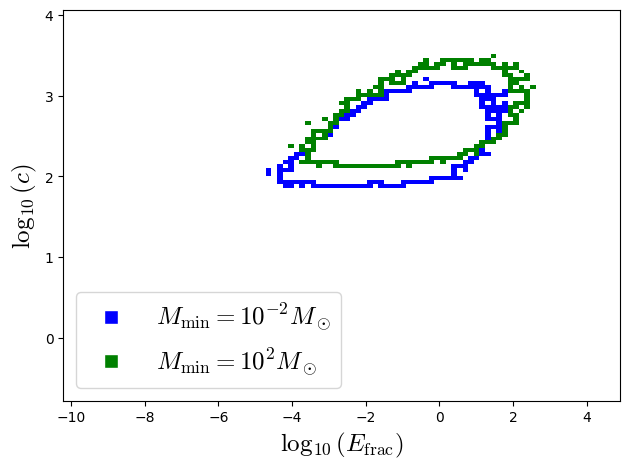

In [19]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Load Contour lines for 68% and 95%. These are Boolean arrays
contour_line_1eMinus2 = np.load(r'..\Data\countour line 95.0% in Boolean format; M_min=1e-2.npy')
contour_line_1e2 = np.load(r'..\Data\countour line 95.0% in Boolean format; M_min=1e2.npy')

contour_line_1eMinus2_int = contour_line_1eMinus2.astype(int)
contour_line_1e2_int = 2*contour_line_1e2.astype(int) # I multiply by 2 to differentiate the 95% line from the 68% line

both_contour_lines = contour_line_1eMinus2_int + contour_line_1e2_int


# Create a colormap: 0 -> white, 1 -> blue, 2 -> green
cmap = ListedColormap(['white', 'blue', 'green'])

# Define normalization: values are 0, 1, and 2
norm = BoundaryNorm([0, 1, 2, 3], cmap.N)

mesh = plt.pcolormesh(Efrac_bins, c_bins, both_contour_lines.T, cmap=cmap, norm=norm, shading='flat')

plt.xlabel(r"$\log_{10}(E_{\rm frac})$", fontsize=18)
plt.ylabel(r"$\log_{10}(c)$", fontsize=18)

# Create custom legend
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='blue', markersize=10, label=r'$M_{\rm min} = 10^{-2}M_\odot$'),
           plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='green', markersize=10, label=r'$M_{\rm min} = 10^2M_\odot$')]

plt.legend(handles=handles, loc='lower left', fontsize=18)


plt.tight_layout()
# plt.savefig("Contour_lines_95_percent.pdf")

plt.show()